In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import draw
from skimage import transform
sns.set_theme(style='whitegrid')
plt.rcParams["figure.figsize"] = (10,10)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)



def polygon2mask(polygon):
    """
    Create an image mask from polygon coordinates
    """
    vertex_row_coords, vertex_col_coords, shape = polygon[:, 1], polygon[:, 0], (450, 600)
    
    fill_row_coords, fill_col_coords = draw.polygon(vertex_row_coords, vertex_col_coords, shape)
    mask = np.zeros(shape, dtype=float)
    mask[fill_row_coords, fill_col_coords] = 1.
    mask = transform.resize(mask, (224, 224))
    return mask


def confidence_interval_correlation(data, size=10000, attribute='trust'):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # Create an empty array to store replicates
    bs_replicates = np.empty(size)
    
    np.random.seed(42)
    # Create bootstrap replicates as much as size
    for i in range(size):
        # Create a bootstrap sample
        bs_sample = data.sample(data.shape[0], replace=True)
        # Get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = stats.spearmanr(bs_sample[attribute], bs_sample['overlap'])[0]
    
    return np.percentile(bs_replicates, [2.5, 97.5])

def confidence_interval(data, size=10000, func=np.mean):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # Create an empty array to store replicates
    bs_replicates = np.empty(size)
    
    np.random.seed(42)
    # Create bootstrap replicates as much as size
    for i in range(size):
        # Create a bootstrap sample
        bs_sample = np.random.choice(data,size=len(data))
        # Get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample)
    
    return np.percentile(bs_replicates, [2.5, 97.5])


mel_class_labels = ['TRBL', 'BDG', 'WLSA', 'ESA', 'GP', 'PV', 'PRL']
nev_class_labels = ['APC', 'MS', 'OPC']
char_class_labels = mel_class_labels+nev_class_labels + ['PLR', 'PES', 'PIF', 'SPC', 'MVP', 'PRLC', 'PLF', 'PDES']

mappings = {
	'thick reticular or branched lines': 'TRBL',
	'dicke retikuläre oder verzweigte Linien': 'TRBL',

	'eccentrically located structureless area': 'ESA',
	'exzentrisch gelegenes, strukturloses Areal jeglicher Farbe, außer hautfarben, weiß und grau': 'ESA',

	'grey patterns': 'GP',
	'graue Muster': 'GP',

	'polymorphous vessels': 'PV',
	'polymorphe Gefäße': 'PV',

	'pseudopods or radial lines at the lesion margin that do not occupy the entire lesional circumference': 'PRL',
	'pseudopodien oder radiale Linien am Läsionsrand, die nicht den gesamten Läsionsumfang einnehmen': 'PRL',

	'black dots or globules in the periphery of the lesion': 'BDG',
	'schwarze Punkte oder Schollen in der Läsionsperipherie': 'BDG',

	'white lines or white structureless area': 'WLSA',
	'weiße Linien oder weißes strukturloses Areal': 'WLSA',

	'parallel lines on ridges (acral lesions only)': 'PLR',
	'parallele Linien auf den Leisten (nur akrale Läsionen)': 'PLR',

	'pigmentation extends beyond the area of the scar (only after excision)': 'PES',
	'pigmentierung überschreitet Narbenareal (nur nach Entfernung)': 'PES',

	'pigmentation invades the openings of hair follicles (facial lesions)': 'PIF',
	'pigmentierung überschreitet Follikelöffnung (Gesichtsläsionen)': 'PIF',

	'only one pattern and only one colour': 'OPC',
	'nur ein Muster und nur eine Farbe': 'OPC',

	'symmetrical combination of patterns and;or colours': 'SPC',
	'symmetrische Kombination von Mustern und;oder Farben': 'SPC',

	'monomorphic vascular pattern': 'MVP',
	'monomorphes Gefäßmuster': 'MVP',

	'pseudopods or radial lines at the lesional margin involving the entire lesional circumference': 'PRLC',
	'pseudopodien oder radiale Linien am Läsionsrand über den gesamten Läsionsumfang': 'PRLC',

	'parallel lines in the furrows (acral lesions only)': 'PLF',
	'parallele Linien in den Furchen (nur akrale Läsionen)': 'PLF',

	'pigmentation does not extend beyond the area of the scar (only after excision)': 'PDES',
	'pigmentierung überschreitet Narbe nicht (nur nach Entfernung)': 'PDES',

	'asymmetric combination of multiple patterns or colours in the absence of other melanoma criteria': 'APC',
	'asymmetrische Kombination mehrerer Muster und;oder Farben ohne weitere Melanomkriterien': 'APC',

	'melanoma simulator': 'MS',
	'melanomsimulator': 'MS',
    
	'please select at least one explanation': 'XX',
	'bitte wählen Sie mindestens eine Erklärung aus.': 'XX',
    'andere (bitte angeben)': 'XX'
}


corpus = char_class_labels
vectorizer = CountVectorizer()
vectorizer.fit(corpus)

predictions_path = "/home/kti01/Documents/My Files/Projects/Overlap/characteristics_classifier/attributions"
phase1_path = "/home/kti01/Documents/My Files/Projects/Overlap/data/phase1"
phase3_path = "/home/kti01/Documents/My Files/Projects/Overlap/data/phase3"
phase2_path = "/home/kti01/Documents/My Files/Projects/Overlap/data/phase2"
metadata_phase1 = pd.read_pickle(os.path.join(phase1_path, "metadata_phase1.pkl")).drop_duplicates(subset=['participant', 'mask'])
metadata_phase3 = pd.read_csv(os.path.join(phase3_path, "metadata_phase3.csv"))
metadata_phase3 = metadata_phase3[~metadata_phase3.issues.isin(['Insufficient Image Quality', 'unzureichende Bildqualität'])]

metadata_phase1['prediction'] = np.floor(metadata_phase1['prediction'])
metadata_phase3['prediction'] = np.floor(metadata_phase3['prediction'])

# Explanation overlap

In [2]:
%%time
overlaps = []
participants = []
masks = []
doc_preds = []
ai_preds = []
trusts = []
predictions = []


for idx, row in metadata_phase1.iterrows():
    
    if row.participant in ['e21', 'e41', 'e70', 'e87', 'g71']:
        continue
    
    mask = str(int(row['mask']))
    ai_pred = pd.read_csv(os.path.join(predictions_path, mask, 'predictions_'+mask+'.csv'))
    ai_pred = list(ai_pred[ai_pred['confidence'].isin(['strong', 'some'])]['label'])
    #ai_pred = list(ai_pred[ai_pred['confidence'] != 'low']['label'])
    if len(ai_pred) == 0:
        ai_pred = pd.read_csv(os.path.join(predictions_path, mask, 'predictions_'+mask+'.csv'))
        ai_pred = list(ai_pred['label'])
    ai_pred = [mappings[pred] for pred in ai_pred]
    
    # Select only the characteristics that the doctor predicted.
    doc_pred = row[char_class_labels]
    doc_pred = list(doc_pred[doc_pred == 1].index)

    if len(doc_pred) == 0:
        continue

    doc_preds.append(doc_pred)
    ai_preds.append(ai_pred)

    ai_pred = vectorizer.transform([' '.join(ai_pred)]).toarray()[0]
    doc_pred = vectorizer.transform([' '.join(doc_pred)]).toarray()[0]

    jacc = metrics.jaccard_score(doc_pred, ai_pred)
    dice = metrics.f1_score(doc_pred, ai_pred)
    ov = (ai_pred*doc_pred).sum()/min(ai_pred.sum(), doc_pred.sum())

    overlap = dice
    
    overlaps.append(overlap)
    participants.append(row['participant'])
    masks.append(row['mask'])
    predictions.append(row['prediction'])
    

overlap_df = pd.DataFrame({'participant': participants, 'mask': masks, 'overlap': overlaps,
                          'doc_pred': doc_preds, 'ai_pred': ai_preds, 'prediction_phase1': predictions})
overlap_df = pd.merge(overlap_df, metadata_phase3,  how='left', left_on=['participant','mask'], right_on =['participant','mask']).dropna()

"""
If phase 3 prediction is different from phase 1, drop the instance since it cant be used for overlap calculation
"""
overlap_df = overlap_df[overlap_df.prediction_phase1 == overlap_df.prediction]
overlap_df['same_as_ai'] = (overlap_df.prediction == overlap_df.AI_prediction).astype(int)
#overlap_df = overlap_df[overlap_df['same_as_ai'] == 1]
df = overlap_df[overlap_df.prediction.isin([0, 1])]
print(df.overlap.mean())
print(confidence_interval(df.overlap))
print(df.shape)

0.26880874456632037
[0.24991337 0.28835792]
(1089, 16)
CPU times: user 4.6 s, sys: 25.4 ms, total: 4.63 s
Wall time: 4.63 s


## Correlation with Trust

Correlation= 0.08728498066009079,   P-val= 0.009959361530870127
95% CI= [0.02187744 0.15416581]
n= 871


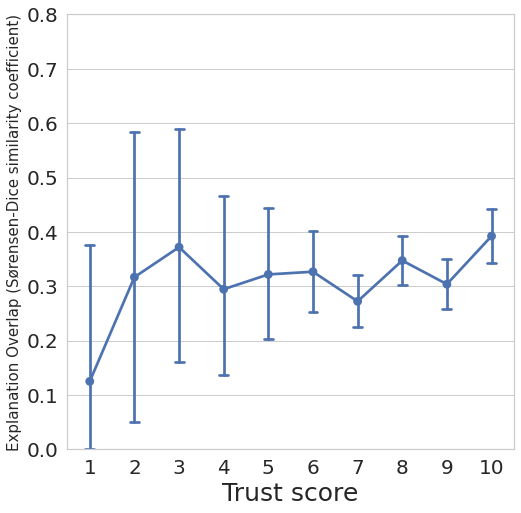

In [5]:
attribute = 'trust'
same_as_ai = True
classes = [0, 1]
overlap = overlap_df.copy()
overlap = overlap[overlap.prediction_phase1.isin(classes)]
overlap[attribute] = overlap[attribute].astype(int)

# Test correlation with all data or only when the doc predictions are same as the AI predictions
if same_as_ai:
    overlap = overlap[overlap['prediction'] == overlap['AI_prediction']]

c, p = stats.spearmanr(overlap['overlap'], overlap[attribute])
print('Correlation=', c, end=',   ')
print('P-val=', p)
print('95% CI=', confidence_interval_correlation(overlap, attribute=attribute))
print('n=', overlap.shape[0])

if 0 in classes and 1 in classes:
    color = None
    save_name = 'exp_overlap'
    class_info = ''
elif 0 in classes:
    color = '#114516'
    save_name = 'nevus_exp_overlap'
    class_info = ' for nevus diagnoses'
    fontsize=23
else:
    color = 'darkred'
    save_name = 'melanoma_exp_overlap'
    class_info = ' for melanoma diagnoses'
g = sns.pointplot(data=overlap, x=attribute, y="overlap", n_boot=10000, seed=42, capsize=.2)
g.figure.set_size_inches(8, 8)
g.set_xlabel('Trust score'+class_info, fontsize=25)
g.set_ylabel('Explanation Overlap (Sørensen-Dice similarity coefficient)', fontsize=15)
plt.ylim(0, 0.8)
g.tick_params(axis='both', which='major', labelsize=20)
if same_as_ai:
    save_name += '_same_AI'
#plt.savefig("/home/kti01/Documents/My Files/Projects/Overlap/plots/overlap/"+save_name+".pdf", dpi=500, bbox_inches='tight')

Correlation= -0.10932044037117769,   P-val= 0.01397309706364031
95% CI= [-0.19587877 -0.02430153]
n= 505


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


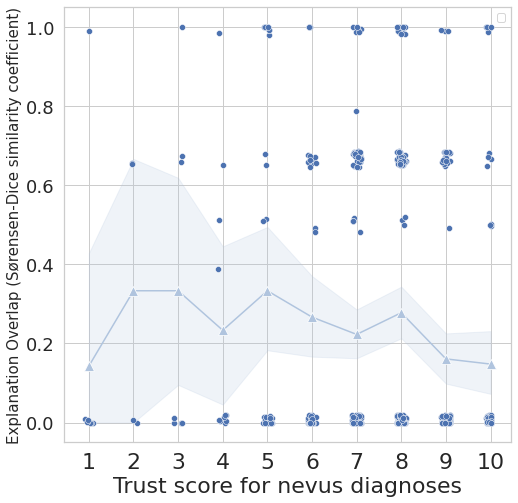

In [8]:
attribute = 'trust'
same_as_ai = True
classes = [0]
overlap = overlap_df.copy()
overlap = overlap[overlap.prediction_phase1.isin(classes)]
overlap[attribute] = overlap[attribute].astype(int)

# Test correlation with all data or only when the doc predictions are same as the AI predictions
if same_as_ai:
    overlap = overlap[overlap['prediction'] == overlap['AI_prediction']]

c, p = stats.spearmanr(overlap['overlap'], overlap[attribute])
print('Correlation=', c, end=',   ')
print('P-val=', p)
print('95% CI=', confidence_interval_correlation(overlap, attribute=attribute))
print('n=', overlap.shape[0])

if 0 in classes and 1 in classes:
    color = None
    save_name = 'exp_overlap'
    class_info = ''
elif 0 in classes:
    color = '#114516'
    save_name = 'nevus_exp_overlap'
    class_info = ' for nevus diagnoses'
    fontsize=23
else:
    color = 'darkred'
    save_name = 'melanoma_exp_overlap'
    class_info = ' for melanoma diagnoses'
    
    
    

non_jittered = overlap.copy()
overlap['overlap'] = overlap['overlap'] + np.random.uniform(-0.02, 0.02, size=len(overlap))
overlap[attribute] = overlap[attribute] + np.random.uniform(-0.1, 0.1, size=len(overlap))
overlap['overlap'] = overlap['overlap'].apply(lambda x: max(0, min(x, 1)))
overlap[attribute] = overlap[attribute].apply(lambda x: max(0, min(x, 10)))


sns.lineplot(data=non_jittered, x=attribute, y="overlap", estimator=np.mean, color='lightsteelblue',
            seed=42, ci=95, n_boot=10000, marker='^', markersize=10, markerfacecolor='lightsteelblue', legend=False)

g = sns.scatterplot(data=overlap, x=attribute, y="overlap")
#g = sns.lmplot(data=overlap, x=attribute, y="overlap", fit_reg=False)

g.figure.set_size_inches(8, 8)

g.set_xlabel('Trust score'+class_info, fontsize=22)
g.set_ylabel('Explanation Overlap (Sørensen-Dice similarity coefficient)', fontsize=15)

#for ax in g.axes.flat:
#    ax.set_xlabel('Trust score'+class_info, fontsize=20)
#    ax.set_ylabel('Explanation Overlap (Sørensen-Dice similarity coefficient)', fontsize=17)

plt.yticks(size=18)
plt.xticks(range(1, 11, 1), size=22)
plt.legend(labelcolor="none", handlelength=0)

if same_as_ai:
    save_name += '_same_AI'

plt.savefig("/home/kti01/Documents/My Files/Projects/Overlap/plots/overlap/"+save_name+".pdf", dpi=500, bbox_inches='tight')

#non_jittered[['overlap', 'trust']].to_csv('../Source Data/Fig5a.csv', index=False)

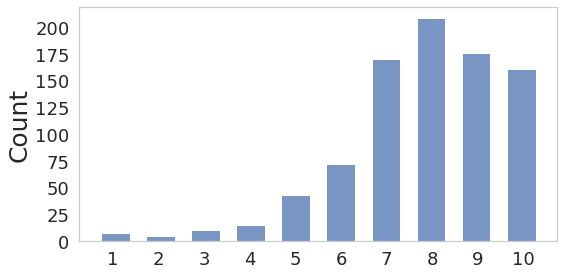

In [22]:
palette = {
    'No AI': '#c6dbef',
    'AI Support': '#6aaed6',
    'XAI Support': '#2070b4'
}

if 0 in classes and 1 in classes:
    color = None
    save_name = 'exp_overlap'
    class_info = ''
elif 0 in classes:
    color = '#114516'
    save_name = 'nevus_exp_overlap'
    class_info = ' when diagnosing nevus'
    fontsize=23
else:
    color = 'darkred'
    save_name = 'melanoma_exp_overlap'
    class_info = ' when diagnosing melanoma'

df = overlap[['trust']].copy()
df = df.dropna()
fig = plt.figure(figsize=(8,4))
ax = sns.histplot(df, x="trust", palette=palette, shrink=7, bins=100)
plt.xticks(range(1, 11))
plt.yticks(size=18)
plt.xticks(size=18)
#plt.xlabel('Trust'+class_info, size=25)
plt.xlabel('')
plt.ylabel('Count', size=25)
plt.grid(False)
fig.tight_layout()
plt.savefig("/home/kti01/Documents/My Files/Projects/Overlap/plots/trust/trust_histplot_phase3", dpi=500, bbox_inches='tight')

In [171]:
ai_preds = {}
doc_preds = {}
for idx, row in metadata_phase1.iterrows():

    mask = str(int(row['mask']))
    ai_pred = pd.read_csv(os.path.join(predictions_path, mask, 'predictions_'+mask+'.csv'))
    ai_pred = list(ai_pred[ai_pred['confidence'].isin(['strong', 'some'])]['label'])
    #ai_pred = list(ai_pred[ai_pred['confidence'] != 'low']['label'])
    if len(ai_pred) == 0:
        ai_pred = pd.read_csv(os.path.join(predictions_path, mask, 'predictions_'+mask+'.csv'))
        ai_pred = list(ai_pred['label'])
    ai_pred = [mappings[pred] for pred in ai_pred]

    doc_pred = row[char_class_labels]
    doc_pred = list(doc_pred[doc_pred == 1].index)
    
    ai_preds[mask] = ai_pred
    doc_preds[mask] = doc_pred

In [172]:
from collections import Counter
ai_counter = Counter()
doc_counter = Counter()
for k in ai_preds.keys():
    for pred in ai_preds[k]:
        ai_counter[pred] += 1
    for pred in doc_preds[k]:
        doc_counter[pred] += 1

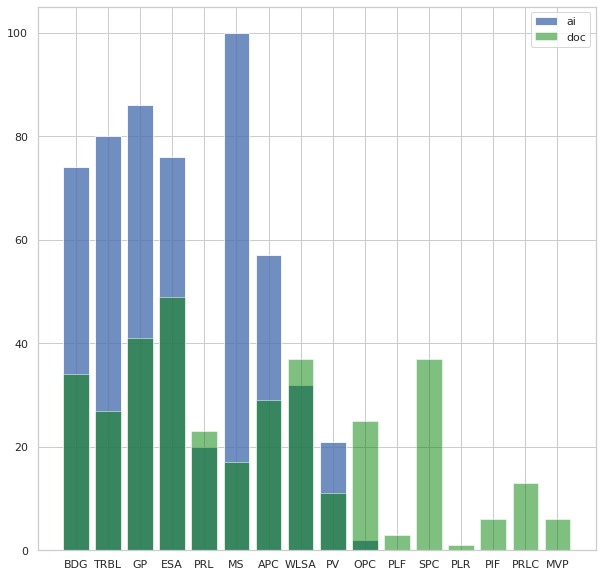

In [188]:
#fig, ax = plt.subplots(1, 2)
plt.bar(height=ai_counter.values(), x=ai_counter.keys(), alpha=0.8, label='ai')
plt.bar(height=doc_counter.values(), x=doc_counter.keys(), color='green', alpha=0.5, label='doc')
plt.legend()

<AxesSubplot:>

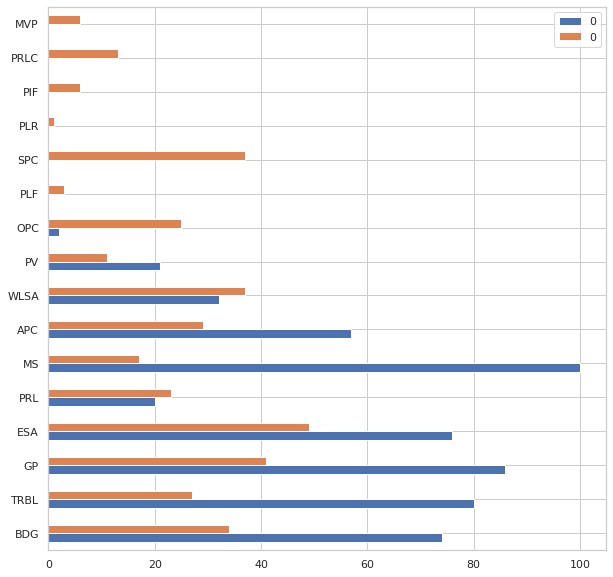

In [181]:
df = pd.concat([pd.DataFrame.from_dict(ai_counter, orient='index'), pd.DataFrame.from_dict(doc_counter, orient='index') ], axis=1)
df.plot.barh()

In [31]:
%%time
ai_preds = {}
for idx, row in metadata_phase1.iterrows():
    
    if row.participant in ['e21', 'e41', 'e70', 'e87', 'g71']:
        continue
    
    if row['prediction'] in [1]:
    
        mask = str(int(row['mask']))
        ai_pred = pd.read_csv(os.path.join(predictions_path, mask, 'predictions_'+mask+'.csv'))
        ai_pred = list(ai_pred[ai_pred['confidence'].isin(['strong', 'some'])]['label'])
        if len(ai_pred) == 0:
            ai_pred = pd.read_csv(os.path.join(predictions_path, mask, 'predictions_'+mask+'.csv'))
            ai_pred = list(ai_pred['label'])
        ai_pred = [mappings[pred] for pred in ai_pred]
        ai_preds[mask] = ai_pred
    
x = list(ai_preds.values())
flat_list = [item for sublist in x for item in sublist]
pd.value_counts(flat_list)

CPU times: user 1.23 s, sys: 16 ms, total: 1.25 s
Wall time: 1.25 s


GP      86
TRBL    80
ESA     76
MS      75
BDG     74
APC     43
WLSA    32
PV      21
PRL     20
OPC      1
dtype: int64